# Oblivious Amplitude Amplification

This demo explains the Oblivious Amplitude Amplification algorithm (OAA) [[2](#OAA)], which can be used as a building block in algorithms such as Hamiltonian simulations. We start with a short recap, then show how to use it in conjunction with the Linear Combination of Unitaries (LCU) algorithm.

### Problem formulation

* **Input:** A $(s, l, 0)$-block-encoding $W$ of a matrix $U$.

* **Promise:**  $U$ is unitary (or close to unitary).

* **Output:** A $(1, l, 0)$-block-encoding of $U$.


## Background

### Recap: Amplitude Amplification

Ref. [[1](#AA)] shows how to use the Grover operator to amplify a specific state. In detail, given a unitary $A$ to prepare a state $|\psi\rangle$:
$$
A|0\rangle = |\psi\rangle = a|\psi_0\rangle + \sqrt{1-a^2}|\psi_1\rangle
$$
and a unitary $R_{\psi_1}$ to implement a reflection over the state $\psi_1$. We want to decrease the amplitude of $R_{\psi_1}$:
$$
R_{\psi_1}(a|\psi_0\rangle + \sqrt{1-a^2}|\psi_1\rangle) = a|\psi+0\rangle - \sqrt{1-a^2}|\psi_1\rangle
$$
where $|\psi_0\rangle$, $|\psi_1\rangle$ define a two-dimensional subspace where the applications of the Grover operator are effectively rotations. To do that we also need to do a reflection about the initial state $|\psi\rangle$:
$$S_\psi = AR_0A^{\dagger}$$
where $R_0$ is a reflection about the $|0\rangle$ state.

The rotations can be used to take the initial vector $|\psi\rangle$ closer to $|\psi_0\rangle$.

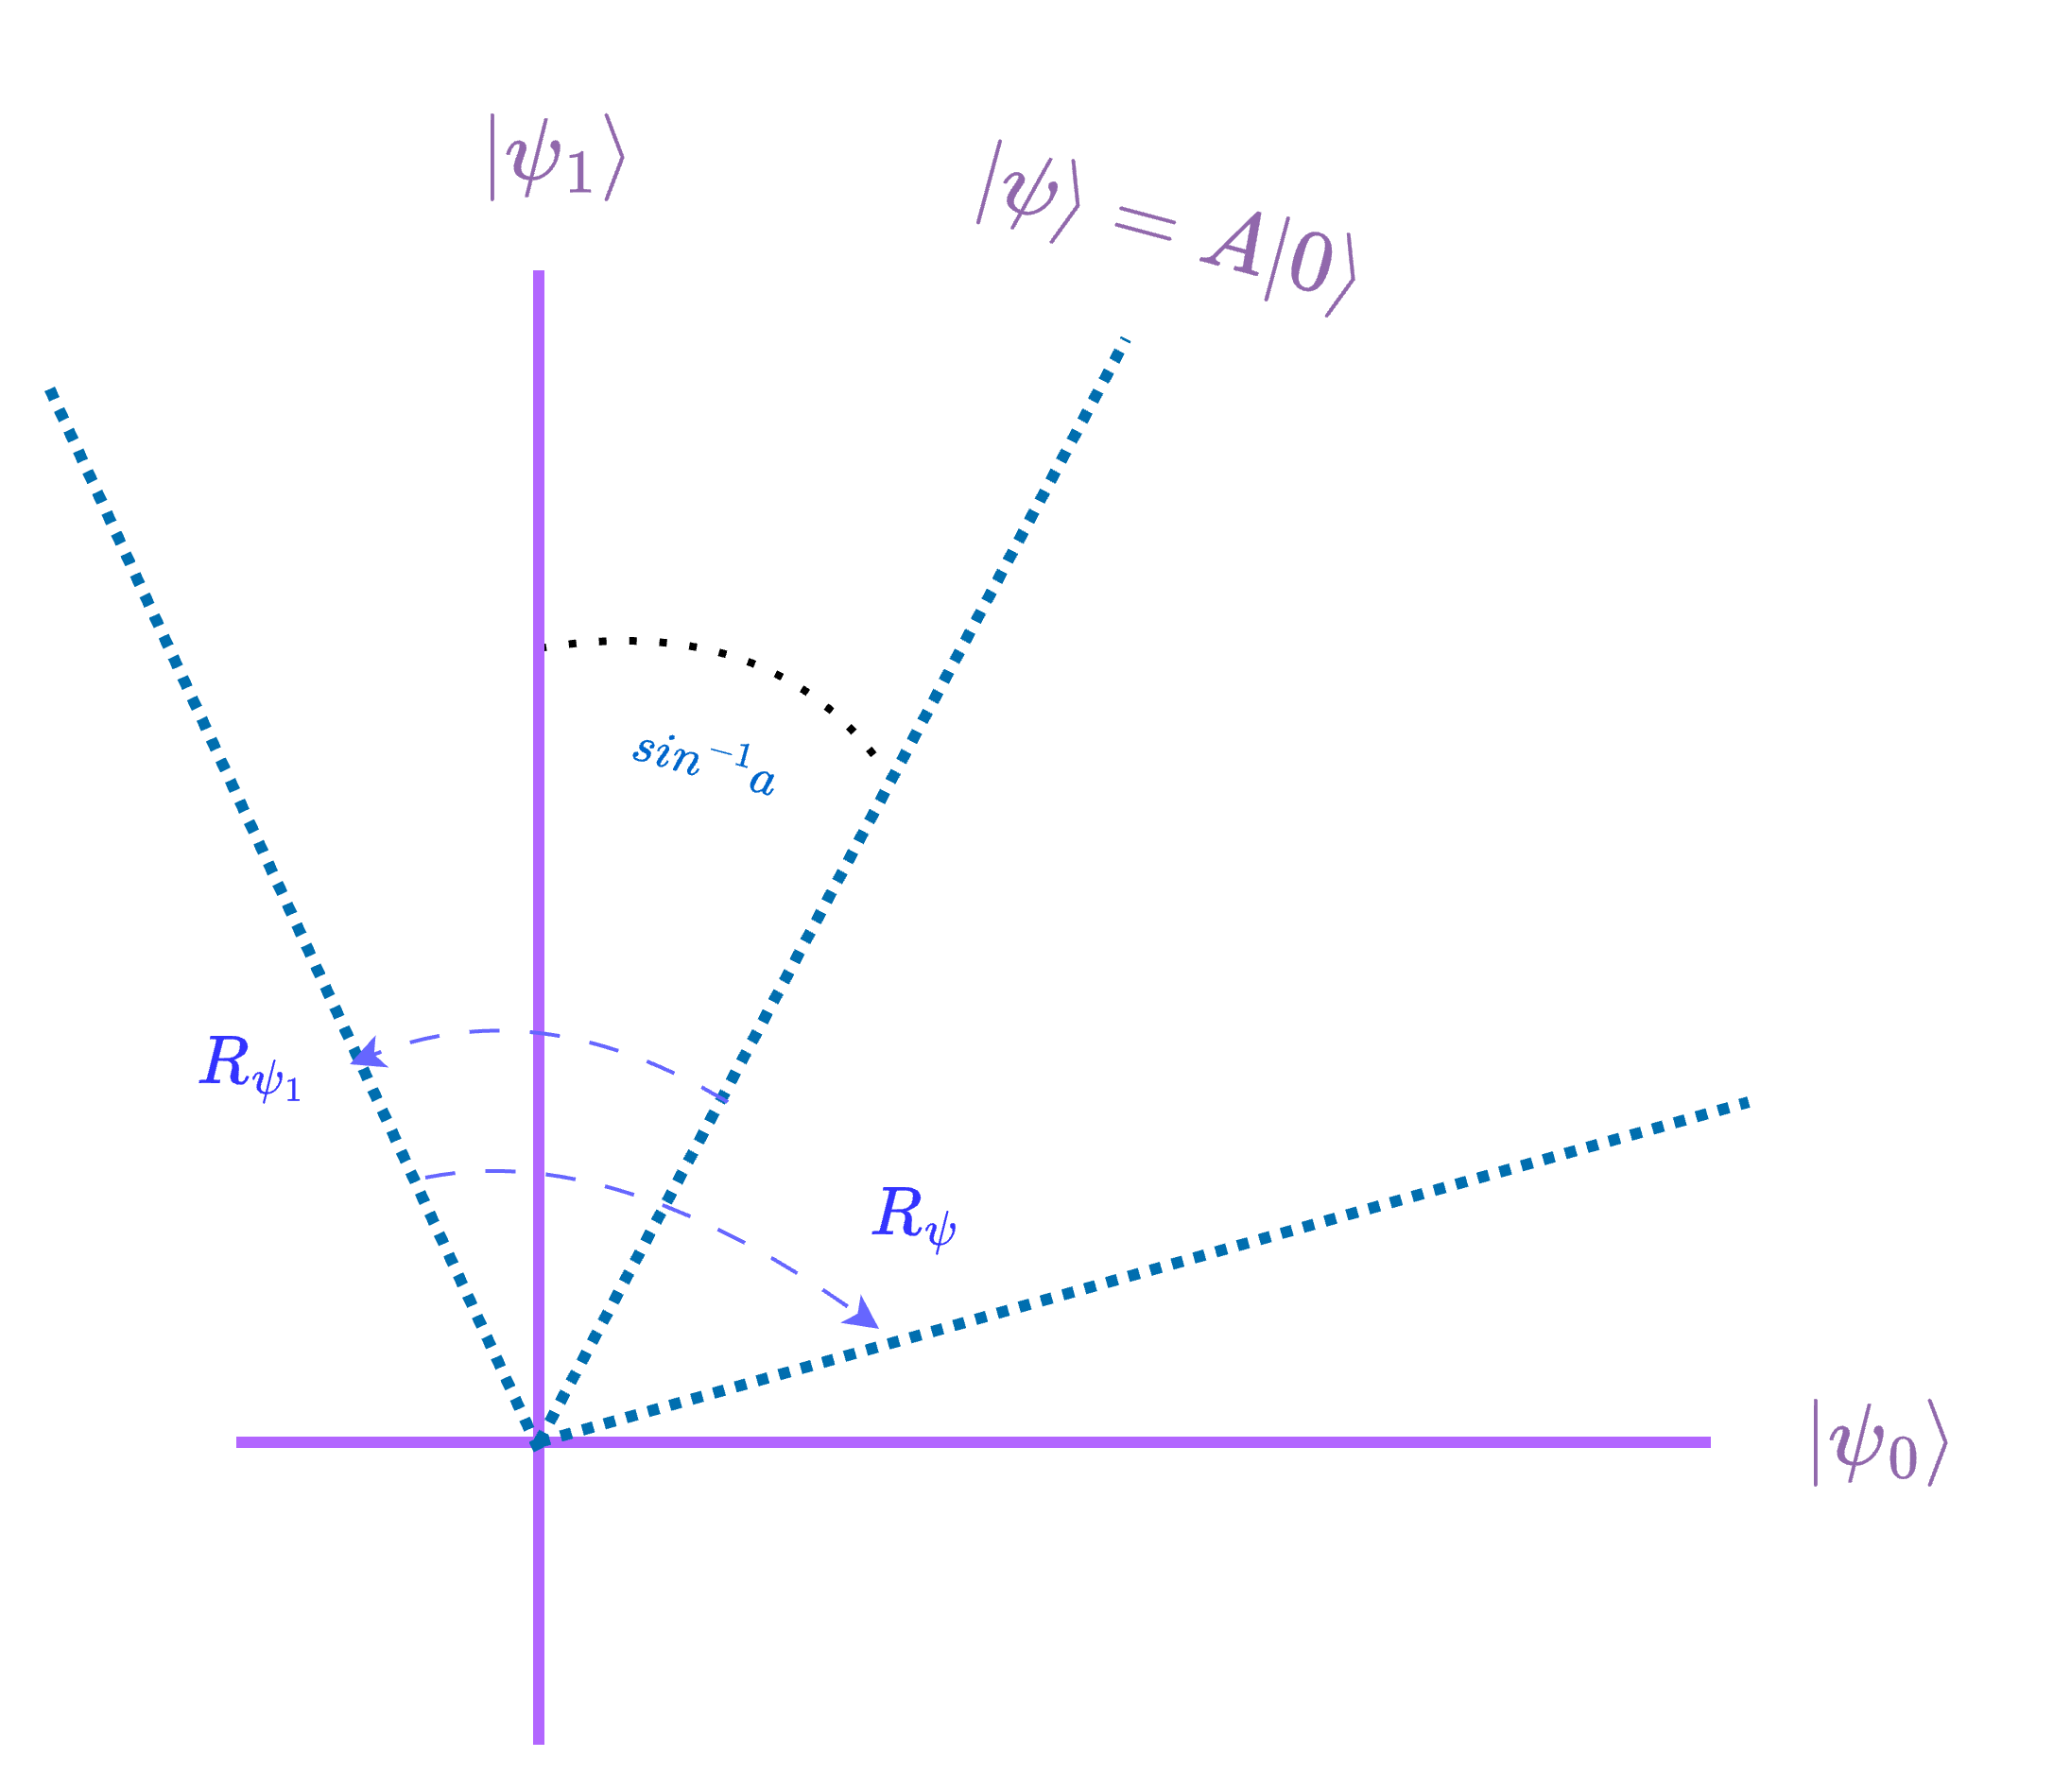

### Why Another Version?

As you might have noticed, the amplification requires the "recipe" $A$ for the preparation of $\psi$, and uses it to perform the reflection around the initial state.

In certain scenarios, such as in Hamiltonian simulations, we might not be able to create the initial state or it is very inefficient. Specifically, we look at a $(s, l, 0)$-block-encoding $W$ of a matrix $U$:
$$
W|0^l\rangle|\psi\rangle = \frac{1}{s}|0^l\rangle U|\psi\rangle + \sqrt{1-\frac{1}{s^2}}|\phi\rangle
$$
(For detailed explanations of block-encodings and Hamiltonian simulations, see [this demo](https://github.com/Classiq/classiq-library/blob/main/algorithms/hamiltonian_simulation/hamiltonian_simulation_with_block_encoding/hamiltonian_simulation_with_block_encoding.ipynb).)

We want to amplify the amplitude of the state that is in the block, i.e., $|0^l\rangle U|\psi\rangle$. This sometimes can be done in post-selection, but if we use $W$ more than once in the algorithm, then the amplitude to sample the "good" states exponentially decreases.

It turns out, however, that if $U$ is unitary, then we can reflect about the initial state $W|0^l\rangle|\psi\rangle$ for any $|\psi\rangle$ using the operator $WRW^\dagger$ where $R=(I-2|0^l\rangle\langle0^l|\otimes) I$, which is analogous to the reflection about the zero state. Then we get the same effective 2D picture! So, to get $|0^l\rangle U |\psi\rangle$ with probability $\thicksim 1$, roughly $\thicksim s$ Grover iterations are needed.

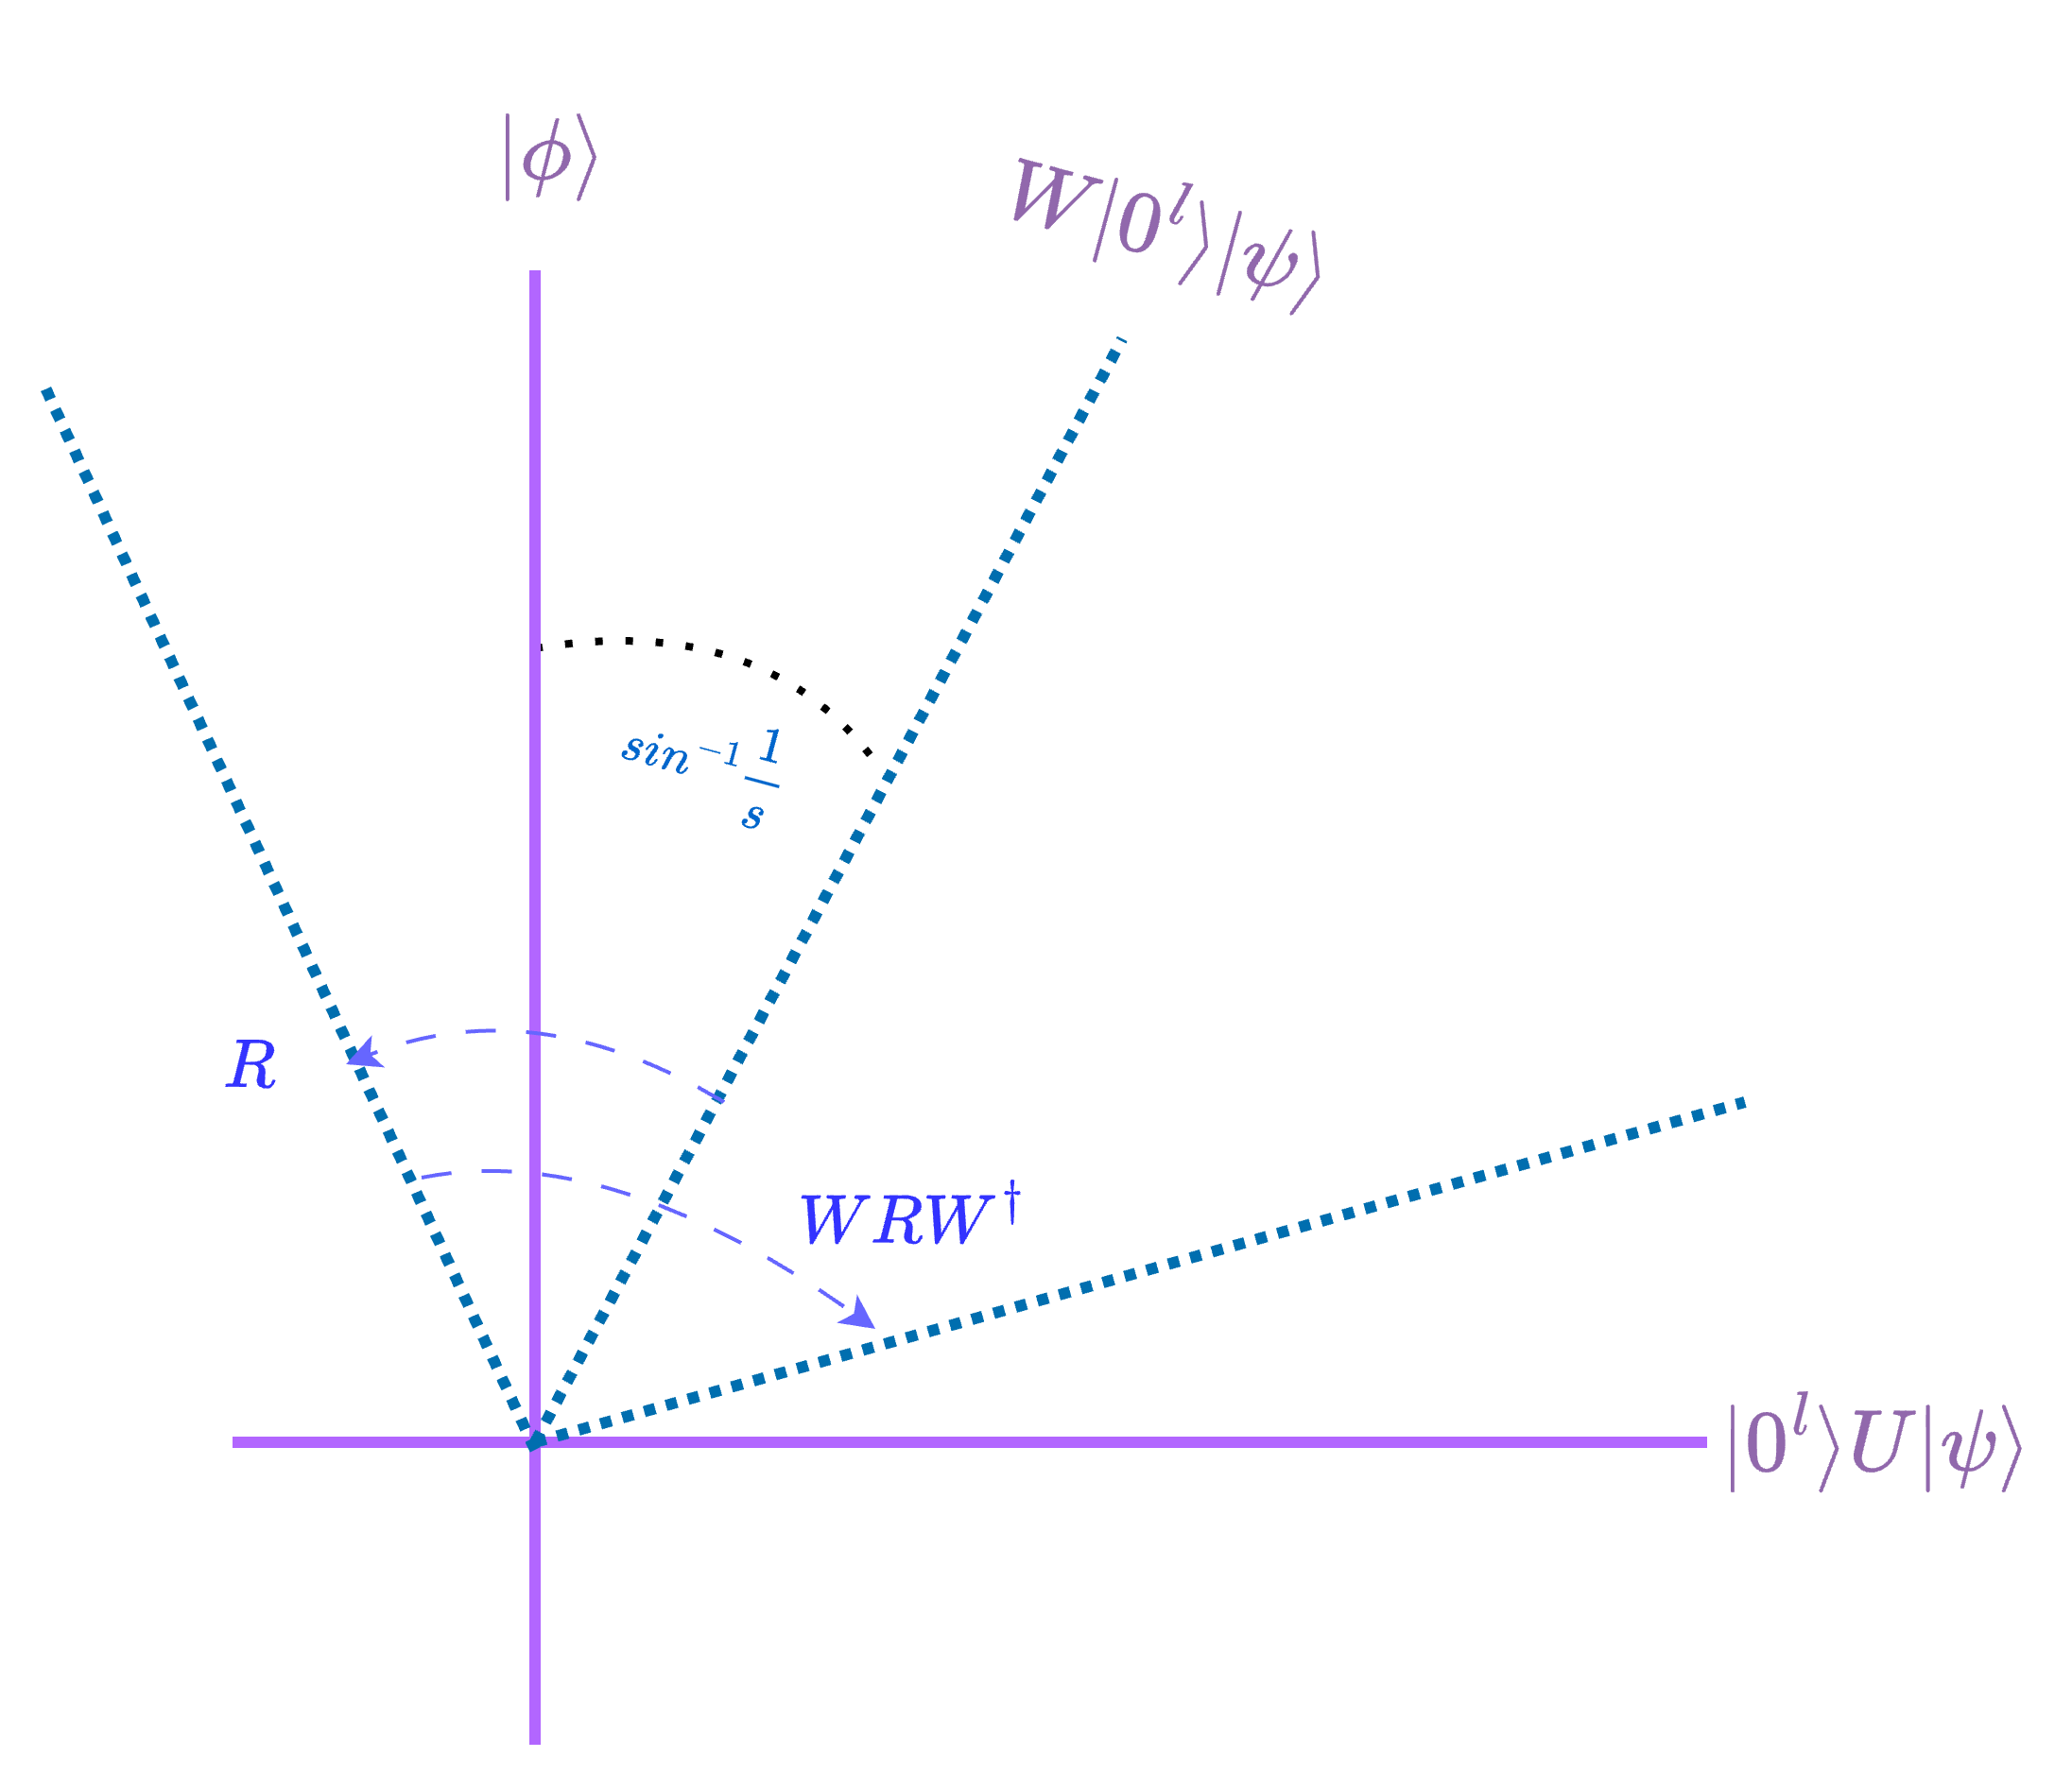

## Building the Algorithm with Classiq

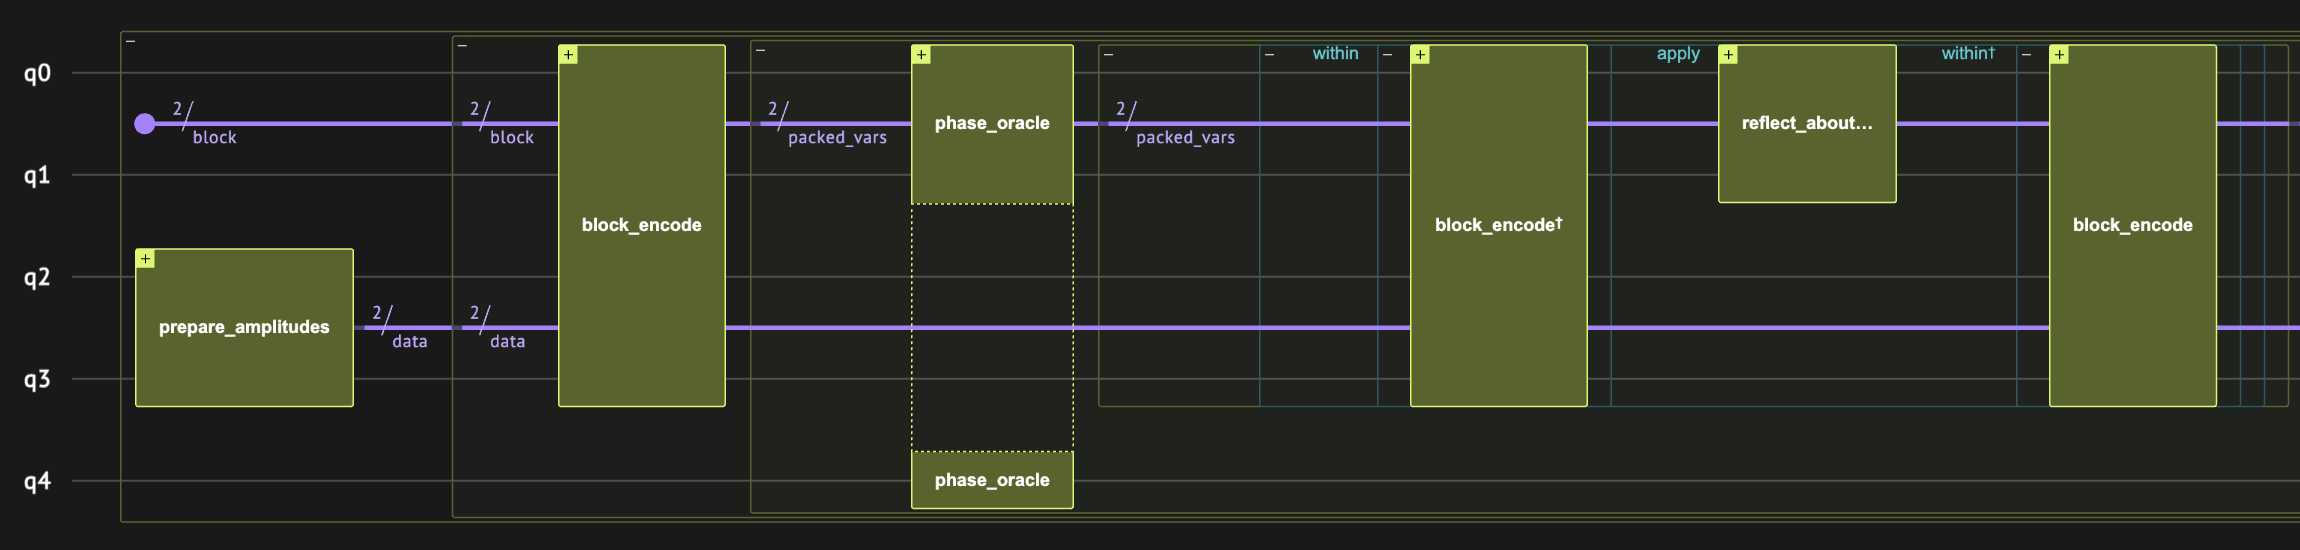

### Example: Unitary LCU Amplification

Here we take the matrix $A = H_0\otimes H_1 = \frac{X_0 + Z_0} {\sqrt{2}} \otimes \frac{X_1 + Z_1} {\sqrt{2}}$ and block-encode it using LCU, creating the matrix $U_A$. In general, though LCU is a combination of unitaries, the result is not necessarily unitary. In this specific example, the matrix $A$ is unitary, and so the encoding can be amplified using oblivious amplitude amplification.

#### Block-encoding the Hamiltonian

First show that the sampled state after the application of $U_A$ is in the wanted block only in $\frac {1}{4}$ of the cases, meaning that in this case $s=2$.
The input $|\psi\rangle$ to $U_A$ is a randomly sampled vector of normalized amplitudes.

In [1]:
import numpy as np

from classiq import *

HAMILTONIAN = 0.5 * (
    Pauli.Z(0) * Pauli.X(1)
    + Pauli.X(0) * Pauli.Z(1)
    + Pauli.X(0) * Pauli.X(1)
    + Pauli.Z(0) * Pauli.Z(1)
)


@qfunc
def block_encode(hamiltonian: SparsePauliOp, data: QArray, block: QNum):
    lcu_pauli(hamiltonian, data, block)


@qfunc
def main(data: Output[QNum], block: Output[QNum]):
    allocate(2, block)

    # initialize a random vector
    np.random.seed(1)
    amps = np.random.rand(4)
    amps = (amps / np.linalg.norm(amps)).tolist()
    prepare_amplitudes(amps, 0, data)

    block_encode(HAMILTONIAN, data, block)


qprog = synthesize(main)
result = execute(qprog).result_value()

Print the "good" states:

In [2]:
df = result.dataframe
df[df.block == 0]

,data,block,count,probability,bitstring
0,0,0,350,0.170898,0000
5,2,0,118,0.057617,0010
9,1,0,62,0.030273,0001


In [3]:
print("Fraction of `good` states:", df[df.block == 0].probability.sum())

Fraction of `good` states: 0.2587890625


#### Block-encoding Amplification

Now we wrap $U_A$ with the oblivious amplitude amplification scheme. It is almost like regular Grover, except that it does not take the initial state preparation to the Grover operator. Also, the Grover diffuser only works on the block qubits. (We take advantage of the language [capturing](https://docs.classiq.io/latest/qmod-reference/language-reference/operators/?h=opera#capturing-context-variables-and-parameters) mechanism.)

The `block_oracle` ($R$ in the used notation) operates on the block qubits and checks that they are in the wanted block (i.e., equal to the state $|00\rangle$). The $W$ operator is represented by the function `block_encoding`.

As the original total amplitude of the "good states" is $\frac{1}{2}$, exactly one Grover iteration will amplify the amplitude to 1.

In [4]:
@qfunc
def oblivious_amplitude_amplification(
    reps: CInt,
    block_encoding: QCallable[QNum, QArray],
    block: QNum,
    data: QArray,
):
    @qperm
    def block_oracle(b: Const[QNum], res: QBit):
        res ^= b == 0

    block_encoding(data, block)
    repeat(
        reps,
        lambda index: grover_operator(
            lambda b: phase_oracle(lambda x, res: block_oracle(x, res), b),
            lambda b: block_encoding(data, b),
            block,
        ),
    )


@qfunc
def main(data: Output[QNum], block: Output[QNum]):
    allocate(2, block)

    # initialize a random vector
    np.random.seed(1)
    amps = np.random.rand(4)
    amps = (amps / np.linalg.norm(amps)).tolist()
    prepare_amplitudes(amps, 0, data)

    oblivious_amplitude_amplification(
        1, lambda _block, _data: block_encode(HAMILTONIAN, _block, _data), block, data
    )


write_qmod(
    main, "oblivious_amplitude_amplification", decimal_precision=20, symbolic_only=False
)
qprog_2 = synthesize(main)
show(qprog_2)
result_2 = execute(qprog_2).result_value()

Quantum program link: https://platform.classiq.io/circuit/32pXxCYSDtOurCFpYfIrkewE4nQ


Print the "good" states:

In [5]:
df = result_2.dataframe
df[df.block == 0]

,data,block,count,probability,bitstring
0,0,0,1347,0.657715,0000
1,2,0,482,0.235352,0010
2,1,0,219,0.106934,0001


In [6]:
print("Fraction of `good` states:", df.probability.sum())
assert df.probability.sum() == 1

Fraction of `good` states: 1.0


### Extending Where $U$ is Non-unitary

It was proven that when $U$ is close to unitary, it is still possible to amplify (using the same operators) and get a good approximation. This is termed "Robust Oblivious Amplitude Amplification" [[3](#ROAA)]. This is usually the case in Hamiltonian simulation when the LCU reprsents a truncated series which is only an approximation of the unitary $e^{-iHt}$.

## References

<a name='AA'>[1]</a>: [Brassard, Gilles, et al. "Quantum Amplitude Amplification and Estimation." arXiv preprint quant-ph/0005055 (2000).](https://arxiv.org/abs/quant-ph/0005055)

<a name='OAA'>[2]</a>: [Berry, Dominic W., et al. "Exponential improvement in precision for simulating sparse Hamiltonians." Proceedings of the forty-sixth annual ACM symposium on Theory of Computing (2014).](https://dl.acm.org/doi/abs/10.1145/2591796.2591854)

<a name='ROAA'>[3]</a>: [Berry, Dominic W., et al. "Simulating Hamiltonian dynamics with a truncated Taylor series." Physical Review Letters 114.9 (2015): 090502.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.090502)
